# Group 1
Fabio Ceruti - Fabio Martino - Alex Lucchini - Jacopo Biggiogera

This notebook contains the code that we used to cluster species on the bounding boxes content.

In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize_with_pad, ResizeMethod
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from random import shuffle
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

## Loading the model to extract the features and sampling the data
This subsection loads the ResNet model and prepares data to be passed for clustering purposes.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Model

base_model = ResNet50(weights='imagenet')  # Read the ImageNet pre-trained ResNet50 model
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)  # We use the output from avg_pool

def extract_feature(model, img):
    # This function takes a RGB image, then return a feature vector.
    x = np.array(tf.image.resize(img, (224, 224))) 
    x = np.float32(x)  # Convert from uint8 to float32
    x = np.expand_dims(x, axis=0)  
    x = preprocess_input(x)  # Subtract the average value of ImagNet for adequating your image to the format the model requires
    feature = model.predict(x, verbose = 0)[0]  # Extract a feature
    feature /= np.linalg.norm(feature)  # Normalize the feature.
    return feature

102967424/102967424 [==============================] - 1s 0us/step


In [19]:
no_context = pd.read_csv('/content/drive/MyDrive/no_context.csv').drop('Unnamed: 0', axis = 1)
no_context.head()

,pic_name,id,bbox,path_name,species
0,2bf2dc73a77dbf99d1c92a64e49afec2.jpg,2199,"[251, 239, 91, 240]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens
1,be0ed422200ed45975ae3954bd5e7325.jpg,2200,"[249, 2, 227, 528]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens
2,dd09c0367b42e7890c127a33eb599043.jpg,2201,"[277, 124, 233, 475]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens
3,69cf3efe1d833d81b80e35b3456df7c5.jpg,2202,"[342, 193, 120, 288]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens
4,1e18c926ccb00243e6859b08ca67c089.jpg,2204,"[401, 309, 25, 58]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens


In [21]:
for i in tqdm(range(len(no_context['path_name']))):
  no_context.loc[i, 'path'] = '/content/drive/MyDrive/Animals_bbcontent/Animals_bbcontent/' + no_context.loc[i, 'species'] + '/' + no_context.loc[i, 'pic_name']

train_val = pd.read_csv('/content/drive/MyDrive/train_val_data_2.csv')
for i in range(len(train_val['path'])):
  train_val.loc[i, 'pic_name'] = train_val.loc[i, 'path'].split('/')[-1]

no_context = pd.merge(no_context, train_val[['pic_name', 'label']], on = 'pic_name')
no_context.head()

100%|██████████| 14939/14939 [00:14<00:00, 1014.74it/s]


,pic_name,id,bbox,path_name,species,path,label
0,2bf2dc73a77dbf99d1c92a64e49afec2.jpg,2199,"[251, 239, 91, 240]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens,/content/drive/MyDrive/Animals_bbcontent/Anima...,7
1,dd09c0367b42e7890c127a33eb599043.jpg,2201,"[277, 124, 233, 475]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens,/content/drive/MyDrive/Animals_bbcontent/Anima...,7
2,69cf3efe1d833d81b80e35b3456df7c5.jpg,2202,"[342, 193, 120, 288]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens,/content/drive/MyDrive/Animals_bbcontent/Anima...,7
3,1dc53163e7253f9eaadd6c51154fb87d.jpg,2206,"[113, 133, 270, 603]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens,/content/drive/MyDrive/Animals_bbcontent/Anima...,7
4,8047c0defacff787b4b689ece9730976.jpg,2209,"[68, 218, 514, 334]",/content/drive/MyDrive/Animals/Picoides pubesc...,Picoides pubescens,/content/drive/MyDrive/Animals_bbcontent/Anima...,7


In [22]:
def path_sampler(df,label_column, column_to_sample, n_per_group = 2, replace = False, seed = 8):
    '''This functon allows to select a subset of the data by saving paths to each observation
    Input: df with all the paths, 
    name of column with lables, 
    name of column with paths, 
    desired observation numbers per group
    
    Returns: df with selected subsample'''
    
    np.random.seed(seed)
    p_samp = []
    lab_samp = []
    for i in set(df[label_column]):
        selected = np.array(df[df[label_column]==i][column_to_sample])
        sample = np.random.choice(selected, size = n_per_group, replace = replace)
        p_samp+=list(sample)
        lab_samp += [i]*n_per_group
    return pd.DataFrame({column_to_sample:p_samp, label_column:lab_samp})

In [23]:
#runing path sampler to select 100 images per class 
#(=1200 pictures that should be enough to see emergence of clusters)

for_clustering = path_sampler(no_context, 'label', 'path_name', n_per_group = 100)

#Reading selected paths as arrays for clustering
arrays_clust = [np.array(PIL.Image.open(i)) for i in tqdm(list(for_clustering['path_name']))]

100%|██████████| 1200/1200 [09:12<00:00,  2.17it/s]


## Extracting the features and running clustering
This section applies clustering to the samples of pictures selected from each specie.

In [24]:
#Extracting features from the model
from matplotlib.image import imread
np.random.seed(4)
features = []
labels = []
for i in tqdm(range(len(arrays_clust))):
    try:
        features.append(extract_feature(model, arrays_clust[i]))
        labels.append(for_clustering.loc[i, 'label'])

    except:
        PIL.Image.fromarray(arrays_clust[i])
features = np.array(features)

100%|██████████| 1200/1200 [04:57<00:00,  4.03it/s]


In [25]:
#Dimensionality reduction using tsne
from sklearn.manifold import TSNE
np.random.seed(4)

tsne = TSNE(n_components=2)
twod_tsne = tsne.fit_transform(features) 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


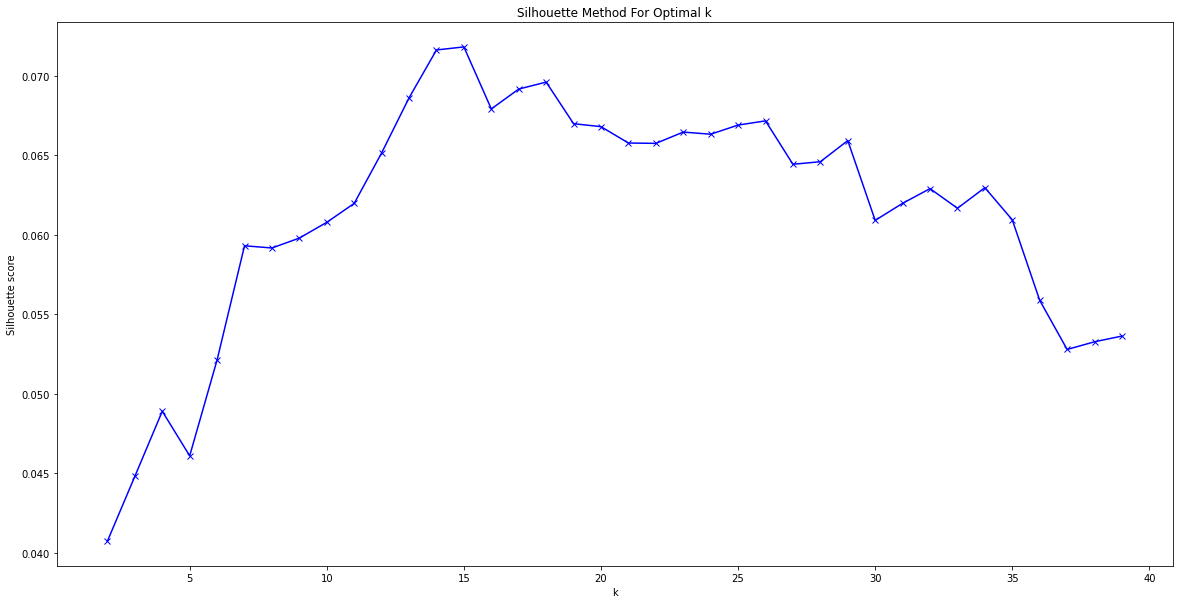

In [26]:
#Using silouhette score to find optimal cluster numbers
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering


silhouettes = []

K = range(2, 40)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg_clustering.fit_predict(features)
    score = silhouette_score(features, agg_cluster_ids)
    silhouettes.append(score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [27]:
#Clustering with optimised number of clusters
from sklearn.cluster import KMeans
n_clusters = 12 #Point at which silhoutette score maximises and thus cluster are most well defined
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)

In [28]:
#Plotting example images from each cluster
import warnings
warnings.filterwarnings("ignore")
for k in range(n_clusters):
    print("Cluster id: k={}".format(k))
    img_ids = [img_id for img_id, cluster_id in enumerate(kmeans.labels_) if cluster_id == k]

    cols = 10
    img_ids = img_ids[0:cols] if cols < len(img_ids) else img_ids # Let's see the top 10 results
    
    # Visualize images assigned to this cluster
    imgs = np.array(arrays_clust)[img_ids]
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(imgs):
        plt.subplot(1, cols, i + 1)
        plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

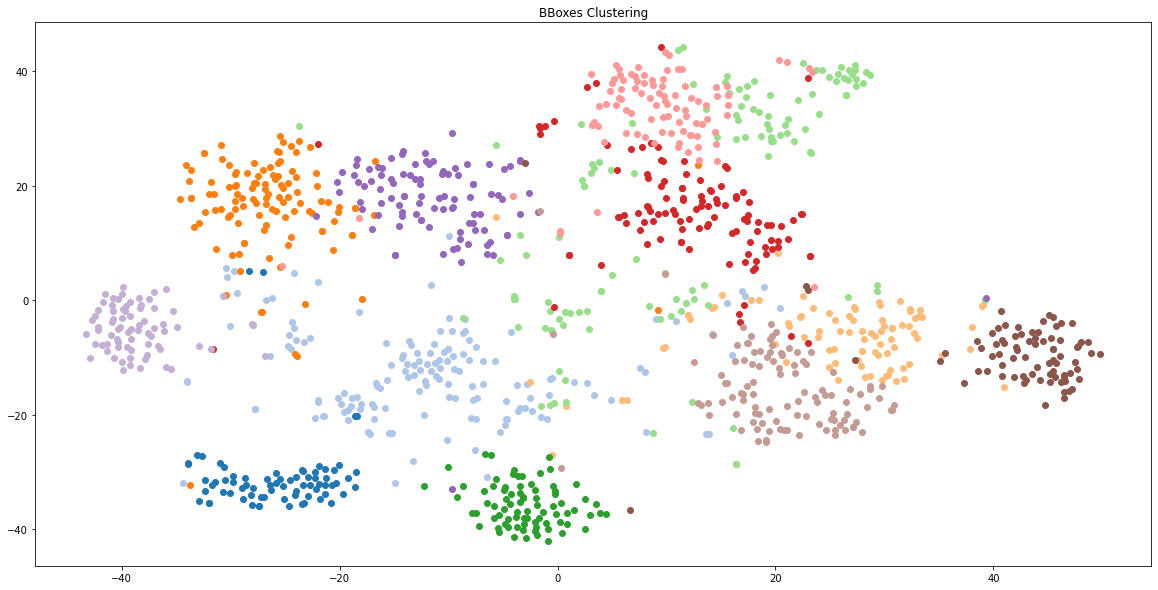

In [29]:
colors = plt.get_cmap("tab20")

plt.figure(figsize = (20,10))
plt.title('BBoxes Clustering')
for c in set(kmeans.labels_):
    indices = np.where(kmeans.labels_==c)
    plt.scatter(twod_tsne[indices,0], twod_tsne[indices, 1], color=colors(c)) #label=clust_dict[c])
#plt.legend(fontsize = 15)
plt.show()

In [30]:
preds = pd.DataFrame()
preds['clusters'] = kmeans.labels_
preds['label'] = labels
preds.head()

,clusters,label
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


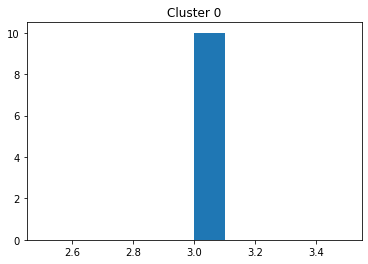

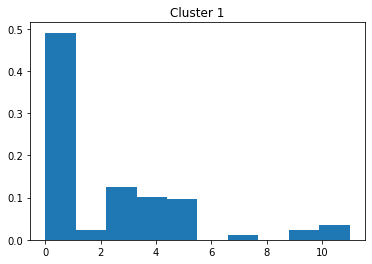

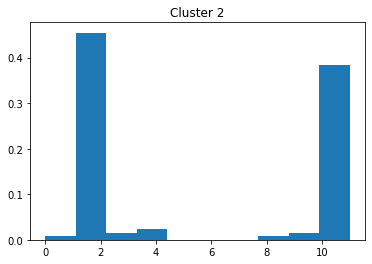

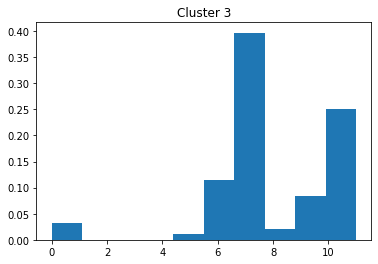

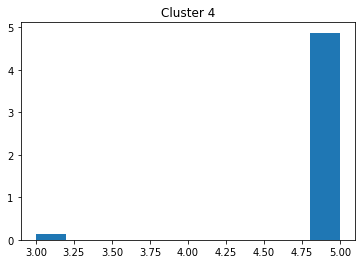

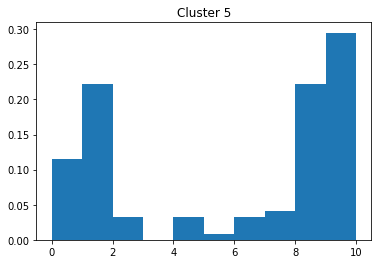

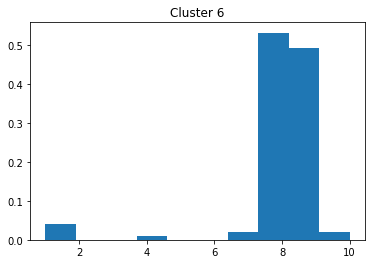

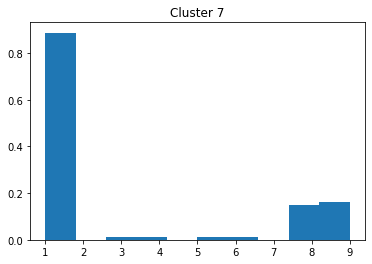

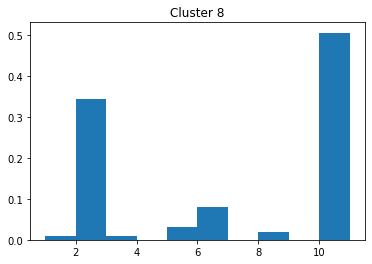

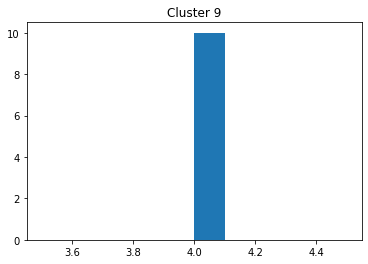

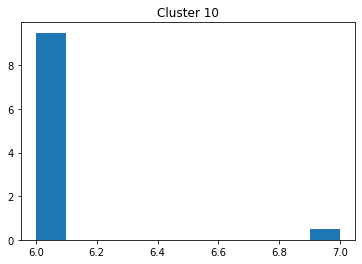

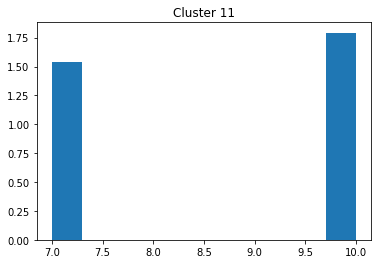

In [31]:
#Visualizing species distributions within each identified cluster
for clust in set(preds['clusters']):
  plt.hist(preds.loc[preds['clusters'] == clust, 'label'], density = True)
  plt.title(f'Cluster {clust}')
  plt.show()

In [ ]:
preds.to_csv('/content/drive/MyDrive/bbcontent_predictions.csv')